In [1]:
import glob
import json
import os

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns
from adjustText import adjust_text

# ローカルモジュールの読み込み設定
from core.config import TARGET_CITIES
from core.definitions import EDGE_DEFINITIONS, EdgeType, NodeType
from runner import AnalysisRunner

# フォント設定
JP_FONT = "IPAexGothic"
sns.set_theme(font=JP_FONT)
plt.rcParams["font.family"] = JP_FONT

# グラフJSONファイルの場所
OUTPUT_DIR = "../output"
JSON_DIR = os.path.join(OUTPUT_DIR, "graphs")
VIS_DIR = os.path.join(OUTPUT_DIR, "visualizations")


# 対象とする自治体の確認


In [2]:
print("Target cities:")
for city in TARGET_CITIES:
    print(f"- {city['name']} ({city['id']})")

Target cities:
- 札幌市 (01100)
- 仙台市 (04100)
- 文京区 (13105)
- 港区 (13103)
- 渋谷区 (13113)
- 足立区 (13121)
- 名古屋市 (23100)
- 大阪市 (27100)
- 広島市 (34100)
- 福岡市 (40130)


# グラフ生成

LLM Agent (LangChain) を用いて、Web 上の情報をもとに各自治体の申請手続きフローをグラフ構造として抽出するパイプライン実行


In [3]:
runner = AnalysisRunner(procedure_name="児童手当 認定請求", output_dir=JSON_DIR)

# 全ての対象都市で分析を実行
results = runner.run_for_all_targets()

# 失敗した都市を特定
failed_cities = [city_id for city_id, result_path in results.items() if result_path is None]

if failed_cities:
    print(f"Analysis completed with failures for the following cities: {', '.join(failed_cities)}")
else:
    print("All analyses completed successfully.")

Starting analysis for 札幌市 (01100) - 児童手当 認定請求...
File ../output/graphs/01100_児童手当 認定請求.json already exists. Skipping.
--------------------------------------------------
Starting analysis for 仙台市 (04100) - 児童手当 認定請求...
File ../output/graphs/04100_児童手当 認定請求.json already exists. Skipping.
--------------------------------------------------
Starting analysis for 文京区 (13105) - 児童手当 認定請求...
File ../output/graphs/13105_児童手当 認定請求.json already exists. Skipping.
--------------------------------------------------
Starting analysis for 港区 (13103) - 児童手当 認定請求...
File ../output/graphs/13103_児童手当 認定請求.json already exists. Skipping.
--------------------------------------------------
Starting analysis for 渋谷区 (13113) - 児童手当 認定請求...
File ../output/graphs/13113_児童手当 認定請求.json already exists. Skipping.
--------------------------------------------------
Starting analysis for 足立区 (13121) - 児童手当 認定請求...
File ../output/graphs/13121_児童手当 認定請求.json already exists. Skipping.
--------------------------------------

# 抽出したグラフの可視化


In [4]:
# データ読み込み
records = []
json_data = {}

for city in TARGET_CITIES:
    file_pattern = os.path.join(JSON_DIR, f"{city['id']}_*.json")
    files = glob.glob(file_pattern)

    target_file = files[0]
    try:
        with open(target_file, encoding="utf-8") as f:
            data = json.load(f)
            json_data[city["id"]] = data

        # アナログデータの抽出
        a_nodes = len(data.get("analog_nodes", []))
        a_edges = len(data.get("analog_edges", []))
        records.append({"City": city["name"], "Mode": "Analog", "Nodes": a_nodes, "Edges": a_edges})

        # デジタルデータの抽出
        d_nodes = len(data.get("digital_nodes", []))
        d_edges = len(data.get("digital_edges", []))
        records.append({"City": city["name"], "Mode": "Digital", "Nodes": d_nodes, "Edges": d_edges})

    except Exception as e:
        print(f"Error processing {city['name']}: {e}")

df = pd.DataFrame(records)

In [5]:
work_df = df.copy()

work_df["node_count"] = work_df["Nodes"]
work_df["edge_count"] = work_df["Edges"]

pivot_df = work_df.pivot_table(
    index="City",
    columns="Mode",
    values=["node_count", "edge_count"],
    aggfunc="sum",
    fill_value=0,
)
pivot_df.columns = [f"{mode} {col.replace('_count', '').capitalize()}s" for col, mode in pivot_df.columns]


cols = ["Analog Nodes", "Analog Edges", "Digital Nodes", "Digital Edges"]
pivot_df[cols].reset_index()

,City,Analog Nodes,Analog Edges,Digital Nodes,Digital Edges
0,仙台市,16,18,11,10
1,名古屋市,15,18,12,12
2,大阪市,17,21,11,10
3,広島市,15,18,9,8
4,文京区,15,17,11,11
5,札幌市,14,16,13,13
6,渋谷区,13,15,12,11
7,港区,16,19,14,13
8,福岡市,7,6,12,11
9,足立区,18,22,10,9


In [6]:
# エッジのスタイル定義
EDGE_STYLES = {edge_enum: meta["meta"] for edge_enum, meta in EDGE_DEFINITIONS.items()}

# ノードの色定義
NODE_COLORS = {
    NodeType.Process_State: "#FFCCCC",  # State
    NodeType.Digital_System: "#E5F5FF",  # System
    NodeType.Digital_Data_Object: "#E5FFE5",  # Data
    NodeType.Physical_Raw_Material: "#FFFFCC",  # Raw
    NodeType.Physical_Processed_Artifact: "#F5F5F5",  # Artifact
}


def get_hierarchical_layout(G: nx.DiGraph):
    """DAGのレイアウトを計算"""
    pos = {}
    # トポロジカルソート
    generations = list(nx.topological_generations(G))
    for x, layer_nodes in enumerate(generations):
        layer_size = len(layer_nodes)
        for y, node in enumerate(layer_nodes):
            y_pos = y - (layer_size - 1) / 2
            pos[node] = (x * 1.5, -y_pos)
    return pos


def create_networkx_graph(nodes: list[dict], edges: list[dict]) -> nx.DiGraph:
    """ノードとエッジリストからNetworkXの有向グラフを作成"""
    G = nx.DiGraph()

    # ノードを追加
    for node in nodes:
        G.add_node(node["id"], label=node["label"], type=node["type"])

    # エッジを追加
    for edge in edges:
        try:
            etype = EdgeType(edge["type"])
            meta = EDGE_STYLES.get(etype, {"base_cost": 0, "color": "black", "style": "solid"})
        except ValueError:
            meta = {"base_cost": 0, "color": "black", "style": "solid"}

        G.add_edge(
            edge["source_id"],
            edge["target_id"],
            type=edge["type"],
            cost=meta["base_cost"],
            color=meta.get("color", "black"),
            style=meta.get("style", "solid"),
        )
    return G


def visualize_graph(G: nx.DiGraph, filename: str):
    """グラフを可視化して表示"""
    plt.figure(figsize=(12, 8))

    # レイアウト計算
    pos = get_hierarchical_layout(G)

    # ノード色の決定
    node_colors = []
    for node in G.nodes():
        node_type_str = G.nodes[node].get("type", "")
        color = "#FFFFFF"
        for ntype, c in NODE_COLORS.items():
            if ntype.value == node_type_str:
                color = c
                break
        node_colors.append(color)

    # 描画
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, edgecolors="gray", alpha=0.9)

    edges = G.edges(data=True)
    for u, v, data in edges:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v)],
            edge_color=data.get("color", "black"),
            style=data.get("style", "solid"),
            arrows=True,
            arrowsize=20,
            width=2,
        )

    labels = {node: G.nodes[node].get("label", node) for node in G.nodes()}
    labels = nx.draw_networkx_labels(G, pos, labels, font_size=9, font_family=JP_FONT)
    for label in labels.values():
        if len(label.get_text()) > 12:
            label.set_rotation(-7)

    # エッジラベルに辺コスト(参考値)を表示
    # edge_labels = {(u, v): f"{d.get('cost')}min" for u, v, d in edges if d.get("cost", 0) > 0}
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_family=JP_FONT)

    plt.axis("off")
    plt.tight_layout()
    save_path = os.path.join(VIS_DIR, filename)
    print(f"Saving to: {save_path}")
    plt.savefig(save_path, dpi=300)
    # plt.show()
    plt.close()


for city in TARGET_CITIES:
    city_id = city["id"]
    city_name = city["name"]
    print(f"Visualizing: {city_id} - {city_name}")
    data = json_data[city_id]

    # アナロググラフ
    if "analog_nodes" in data:
        G_analog = create_networkx_graph(data["analog_nodes"], data["analog_edges"])
        visualize_graph(G_analog, f"{city_id}_analog.png")

    # デジタルグラフ
    if "digital_nodes" in data:
        G_digital = create_networkx_graph(data["digital_nodes"], data["digital_edges"])
        visualize_graph(G_digital, f"{city_id}_digital.png")

Visualizing: 01100 - 札幌市
Saving to: ../output/visualizations/01100_analog.png
Saving to: ../output/visualizations/01100_digital.png
Visualizing: 04100 - 仙台市
Saving to: ../output/visualizations/04100_analog.png
Saving to: ../output/visualizations/04100_digital.png
Visualizing: 13105 - 文京区
Saving to: ../output/visualizations/13105_analog.png
Saving to: ../output/visualizations/13105_digital.png
Visualizing: 13103 - 港区
Saving to: ../output/visualizations/13103_analog.png
Saving to: ../output/visualizations/13103_digital.png
Visualizing: 13113 - 渋谷区
Saving to: ../output/visualizations/13113_analog.png
Saving to: ../output/visualizations/13113_digital.png
Visualizing: 13121 - 足立区
Saving to: ../output/visualizations/13121_analog.png
Saving to: ../output/visualizations/13121_digital.png
Visualizing: 23100 - 名古屋市
Saving to: ../output/visualizations/23100_analog.png
Saving to: ../output/visualizations/23100_digital.png
Visualizing: 27100 - 大阪市
Saving to: ../output/visualizations/27100_analog.pn

# データの妥当性検証(外れ値検出)


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


3 [ 0.48804771 -0.47837373]
15 [0.47443704 0.10417524]
9 [0.99911373 0.2761543 ]
19 [-0.74401102  0.30650534]


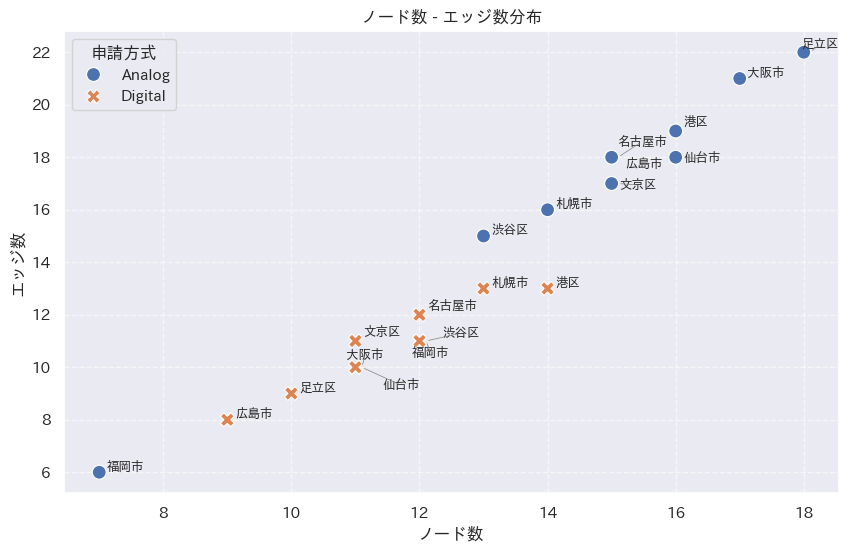

In [7]:
# 散布図による全体像の確認 (ノード数 vs エッジ数)
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df,
    x="Nodes",
    y="Edges",
    hue="Mode",
    style="Mode",
    s=100,
)
plt.xlabel("ノード数")
plt.ylabel("エッジ数")
plt.legend(title="申請方式", loc="upper left")

# 各点にラベル付け
texts = []
for _, row in df.iterrows():
    texts.append(plt.text(row["Nodes"] + 0.1, row["Edges"], row["City"], fontsize=9))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray", lw=0.5), force_text=1, force_points=1)
plt.title("ノード数 - エッジ数分布")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# 構造的複雑さの分析


/tmp/ipykernel_222718/2637535122.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["アナログ", "デジタル"])
/tmp/ipykernel_222718/2637535122.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["アナログ", "デジタル"])


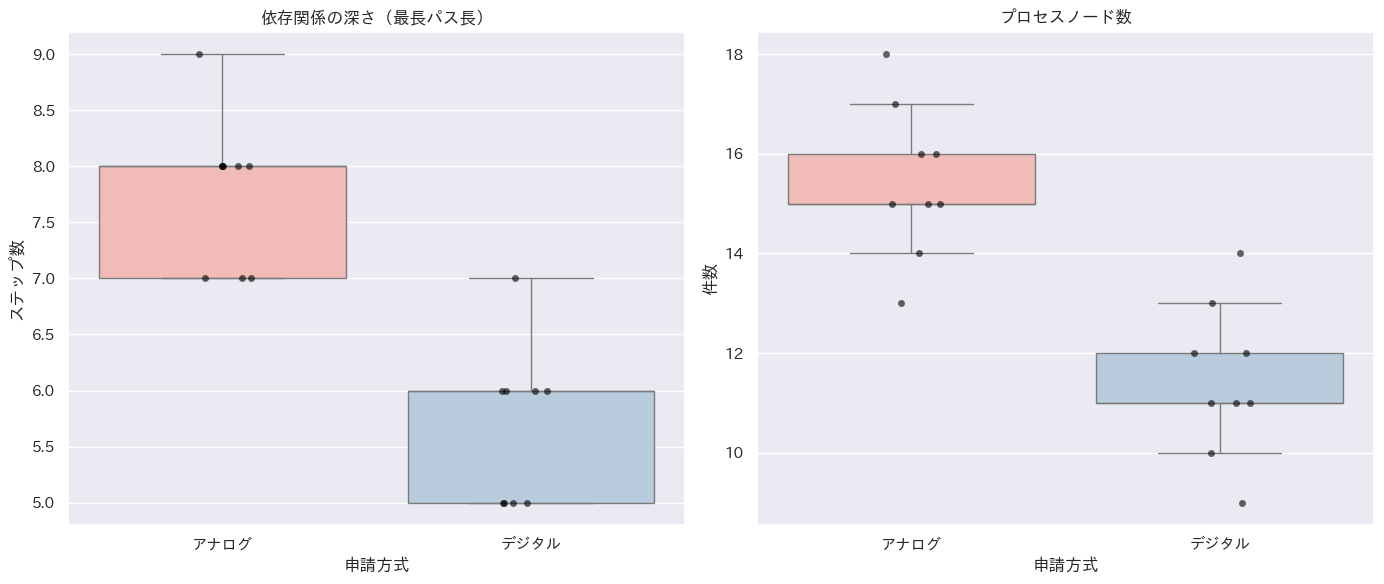

Mode             Analog    Digital
Depth  count   9.000000   9.000000
       mean    7.777778   5.666667
       std     0.666667   0.707107
       min     7.000000   5.000000
       25%     7.000000   5.000000
       50%     8.000000   6.000000
       75%     8.000000   6.000000
       max     9.000000   7.000000
Volume count   9.000000   9.000000
       mean   15.444444  11.444444
       std     1.509231   1.509231
       min    13.000000   9.000000
       25%    15.000000  11.000000
       50%    15.000000  11.000000
       75%    16.000000  12.000000
       max    18.000000  14.000000


In [8]:
def calculate_depth(nodes, edges):
    """DAGの最長パス（深さ）を計算"""
    G = nx.DiGraph()
    for n in nodes:
        G.add_node(n["id"])
    for e in edges:
        G.add_edge(e["source_id"], e["target_id"])
    return nx.dag_longest_path_length(G)


records = []

for city in TARGET_CITIES:
    data = json_data[city["id"]]

    # Analog
    a_nodes = data["analog_nodes"]
    a_edges = data["analog_edges"]
    records.append({"City": city["name"], "Mode": "Analog", "Depth": calculate_depth(a_nodes, a_edges), "Volume": len(a_nodes)})

    # Digital
    d_nodes = data["digital_nodes"]
    d_edges = data["digital_edges"]
    records.append(
        {"City": city["name"], "Mode": "Digital", "Depth": calculate_depth(d_nodes, d_edges), "Volume": len(d_nodes)}
    )

df_depth = pd.DataFrame(records)
# 外れ値の除外
df_depth = df_depth[(df_depth["City"] != "福岡市")]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. 依存関係の深さ
sns.boxplot(data=df_depth, x="Mode", y="Depth", ax=axes[0], palette="Pastel1", showfliers=False, hue="Mode")
sns.stripplot(data=df_depth, x="Mode", y="Depth", color="black", alpha=0.6, ax=axes[0])
axes[0].set_title("依存関係の深さ（最長パス長）")
axes[0].set_ylabel("ステップ数")
axes[0].set_xlabel("申請方式")
axes[0].set_xticklabels(["アナログ", "デジタル"])


# 2. プロセスノード数
sns.boxplot(data=df_depth, x="Mode", y="Volume", ax=axes[1], palette="Pastel1", showfliers=False, hue="Mode")
sns.stripplot(data=df_depth, x="Mode", y="Volume", color="black", alpha=0.6, ax=axes[1])
axes[1].set_title("プロセスノード数")
axes[1].set_ylabel("件数")
axes[1].set_xlabel("申請方式")
axes[1].set_xticklabels(["アナログ", "デジタル"])

plt.tight_layout()
plt.show()

# 統計量
print(df_depth.groupby("Mode")[["Depth", "Volume"]].describe().T)

# メディアスイッチングコストの分析


/tmp/ipykernel_222718/767205598.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(["アナログ", "デジタル"])


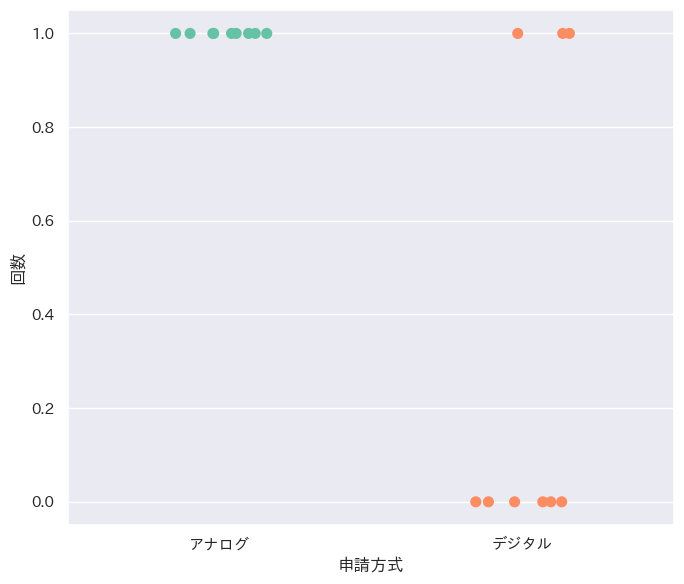

In [9]:
SWITCH_TYPES = ["Physical_Print_From_Digital", "Digital_Photograph_Document"]


def analyze_switching(edges):
    switches = 0
    for e in edges:
        etype = e.get("type")
        if etype in SWITCH_TYPES:
            switches += 1
    return switches


records_switch = []
for city in TARGET_CITIES:
    data = json_data[city["id"]]

    # Analog
    sw = analyze_switching(data.get("analog_edges", []))
    records_switch.append({"City": city["name"], "Mode": "Analog", "MediaSwitches": sw})

    # Digital
    sw = analyze_switching(data.get("digital_edges", []))
    records_switch.append({"City": city["name"], "Mode": "Digital", "MediaSwitches": sw})
df_switch = pd.DataFrame(records_switch)
df_switch = df_switch[(df_switch["City"] != "福岡市")]

# 可視化
fig, axes = plt.subplots(1, 1, figsize=(7, 6))
sns.stripplot(data=df_switch, x="Mode", y="MediaSwitches", jitter=0.2, size=8, palette="Set2", ax=axes, hue="Mode")
axes.set_ylabel("回数")
axes.set_xlabel("申請方式")
axes.set_xticklabels(["アナログ", "デジタル"])
plt.tight_layout()
plt.show()